# AutoML using AutoGluon

Split the data frame between training and test data. Then, train multiple ML models using AutoGluon and evaluate the performance of each model.

In [1]:
import duckdb
import pandas as pd
import plotnine as p9
import numpy as np

df_full_merged = pd.read_parquet('full_merged.parquet')

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
import random
import os

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Split train, calibration, and test

In [3]:
df_train = (df_full_merged
            .copy(deep=True)
            .query("Date >= '2020-01-01' and Date <= '2020-12-31'")
            .reset_index(drop=True))

In [4]:
df_calibration = (df_full_merged
        .copy(deep=True)
        .query("Date >= '2021-01-01' and Date <= '2021-06-30'")
        .reset_index(drop=True))

In [5]:
df_test = (df_full_merged
        .copy(deep=True)
        .query("Date >= '2021-07-01' and Date <= '2021-12-31'")
        .reset_index(drop=True))

Check that the report rate is similar between df_train and df_test.

In [6]:
# Calculate the percentage of each outcome in train data
outcome_rate_train = (df_train['Outcome']
                .value_counts(normalize=True)
                .mul(100)
                .round(2)
                .reset_index()
                .rename(columns={'proportion': 'Outcome Rate (%)'})
)

print("Outcome rate in training data:")
display(outcome_rate_train)

Outcome rate in training data:


,Outcome,Outcome Rate (%)
0,Dismiss,83.31
1,Report,16.69


In [7]:
# Calculate the percentage of each outcome in test data
outcome_rate_test = (df_test['Outcome']
                .value_counts(normalize=True)
                .mul(100)
                .round(2)
                .reset_index()
                .rename(columns={'proportion': 'Outcome Rate (%)'})
)

print("Outcome rate in test data:")
display(outcome_rate_test)

Outcome rate in test data:


,Outcome,Outcome Rate (%)
0,Dismiss,81.81
1,Report,18.19


# Train Models using AutoGluon

By default, AutoGluon excludes the following model types:

* Logistic Regression (see work around below)
* Simple Decision Tree
* Support Vector Machine

Remove `Date` and `AlertID` to avoid training on the columns.

In [8]:
df_train.drop(columns=['Date', 'AlertID'], inplace=True)

In [9]:
label = 'Outcome'

# Set random seed for reproducibility
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
random.seed(42)

ag_predictor = TabularPredictor(label=label,
                            problem_type='binary',
                            eval_metric='roc_auc',
                            log_to_file=True)

ag_predictor.fit(df_train)

No path specified. Models will be saved in: "AutogluonModels\ag-20241220_233439"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
Memory Avail:       18.14 GB / 31.75 GB (57.1%)
Disk Space Avail:   699.32 GB / 951.74 GB (73.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'       

Include logistic regression (a member of the linear model family).

In [10]:
ag_predictor.fit_extra(hyperparameters = {'LR':{'penalty':None}},
                    fit_weighted_ensemble = False)

Fitting 1 L1 models, fit_strategy="sequential" ...
Fitting model: LinearModel ...
	0.6322	 = Validation score   (roc_auc)
	2.17s	 = Training   runtime
	0.01s	 = Validation runtime
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\chiuw\Projects\repro_SynthAML\AutogluonModels\ag-20241220_233439")


# Set Decision Threshold

A decision threshold is needed for metrics like F1, precision, and recall. Calculate the optimal threshold that maximizes the F1 score using the best model.

In [11]:
# training_threshold = (df_train['Outcome']
#                 .value_counts(normalize=True)
#                 .reset_index()
#                 .query("Outcome == 'Report'")
#                 ['proportion']
#                 .iloc[0]
#                 )

# ag_predictor.set_decision_threshold(np.round(training_threshold,3))

best_threshold = ag_predictor.calibrate_decision_threshold(df_calibration, metric='f1')

ag_predictor.set_decision_threshold(best_threshold)

Calibrating decision threshold to optimize metric f1 | Checking 51 thresholds...
Calibrating decision threshold via fine-grained search | Checking 38 thresholds...
	Base Threshold: 0.500	| val: 0.0038
	Best Threshold: 0.169	| val: 0.3671
Updating predictor.decision_threshold from 0.5 -> 0.16899999999999998
	This will impact how prediction probabilities are converted to predictions in binary classification.
	Prediction probabilities of the positive class >0.16899999999999998 will be predicted as the positive class (Report). This can significantly impact metric scores.
	You can update this value via `predictor.set_decision_threshold`.
	You can calculate an optimal decision threshold on the validation data via `predictor.calibrate_decision_threshold()`.


# Save the model

In [12]:
ag_predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\chiuw\Projects\repro_SynthAML\AutogluonModels\ag-20241220_233439")


# Show Leaderboard with Test Set

The leaderboard shows the performance of each model on the test set. Metrics include AUC, F1, precision, and recall.

The leaderboard is sorted by AUC.

In [13]:
leaderboard = ag_predictor.leaderboard(df_test, 
                                    extra_metrics=['roc_auc','f1', 'precision', 'recall']
                                    )

display(leaderboard.iloc[:, :10])

,model,score_test,roc_auc,f1,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val
0,LinearModel,0.668207,0.668207,0.393197,0.279715,0.661616,0.632196,roc_auc,0.034524,0.011028
1,LightGBM,0.667808,0.667808,0.393075,0.281752,0.649832,0.650499,roc_auc,0.004999,0.004000
2,CatBoost,0.665692,0.665692,0.391960,0.279370,0.656566,0.640820,roc_auc,0.009987,0.001983
3,WeightedEnsemble_L2,0.663254,0.663254,0.383533,0.277736,0.619529,0.664960,roc_auc,0.215132,0.065045
4,LightGBMXT,0.659634,0.659634,0.382514,0.271318,0.648148,0.633796,roc_auc,0.003994,0.005553
5,ExtraTreesEntr,0.653899,0.653899,0.358752,0.241540,0.696970,0.620097,roc_auc,0.141286,0.047191
6,NeuralNetTorch,0.653403,0.653403,0.372740,0.257198,0.676768,0.645638,roc_auc,0.050533,0.011976
7,RandomForestEntr,0.652360,0.652360,0.377011,0.259330,0.690236,0.639348,roc_auc,0.108944,0.046270
8,LightGBMLarge,0.652188,0.652188,0.367232,0.276361,0.547138,0.660851,roc_auc,0.009004,0.006000
9,XGBoost,0.648762,0.648762,0.378055,0.268604,0.638047,0.636436,roc_auc,0.022022,0.005001


Sort the leaderboard by F1 score.

In [14]:
display(leaderboard.iloc[:, :10].sort_values('f1', ascending=False))

,model,score_test,roc_auc,f1,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val
0,LinearModel,0.668207,0.668207,0.393197,0.279715,0.661616,0.632196,roc_auc,0.034524,0.011028
1,LightGBM,0.667808,0.667808,0.393075,0.281752,0.649832,0.650499,roc_auc,0.004999,0.004000
2,CatBoost,0.665692,0.665692,0.391960,0.279370,0.656566,0.640820,roc_auc,0.009987,0.001983
3,WeightedEnsemble_L2,0.663254,0.663254,0.383533,0.277736,0.619529,0.664960,roc_auc,0.215132,0.065045
4,LightGBMXT,0.659634,0.659634,0.382514,0.271318,0.648148,0.633796,roc_auc,0.003994,0.005553
9,XGBoost,0.648762,0.648762,0.378055,0.268604,0.638047,0.636436,roc_auc,0.022022,0.005001
7,RandomForestEntr,0.652360,0.652360,0.377011,0.259330,0.690236,0.639348,roc_auc,0.108944,0.046270
6,NeuralNetTorch,0.653403,0.653403,0.372740,0.257198,0.676768,0.645638,roc_auc,0.050533,0.011976
8,LightGBMLarge,0.652188,0.652188,0.367232,0.276361,0.547138,0.660851,roc_auc,0.009004,0.006000
10,RandomForestGini,0.640200,0.640200,0.364519,0.247010,0.695286,0.639712,roc_auc,0.152595,0.047069


# Check model probability predictions

Compare predicted probabilities from three models: `LinearModel`, `CatBoost`, `LightGBM`.

In [17]:
# Get prediction probabilities for both models
logit_probs = ag_predictor.predict_proba(df_test, model='LinearModel')['Report']
catboost_probs = ag_predictor.predict_proba(df_test, model='CatBoost')['Report']
lgbm_probs = ag_predictor.predict_proba(df_test, model='LightGBM')['Report']

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'Probability': np.concatenate([ensemble_probs, catboost_probs, lgbm_probs]),
    'Model': ['LogisticReg'] * len(logit_probs) + ['CatBoost'] * len(catboost_probs) + ['LightGBM'] * len(lgbm_probs)
})

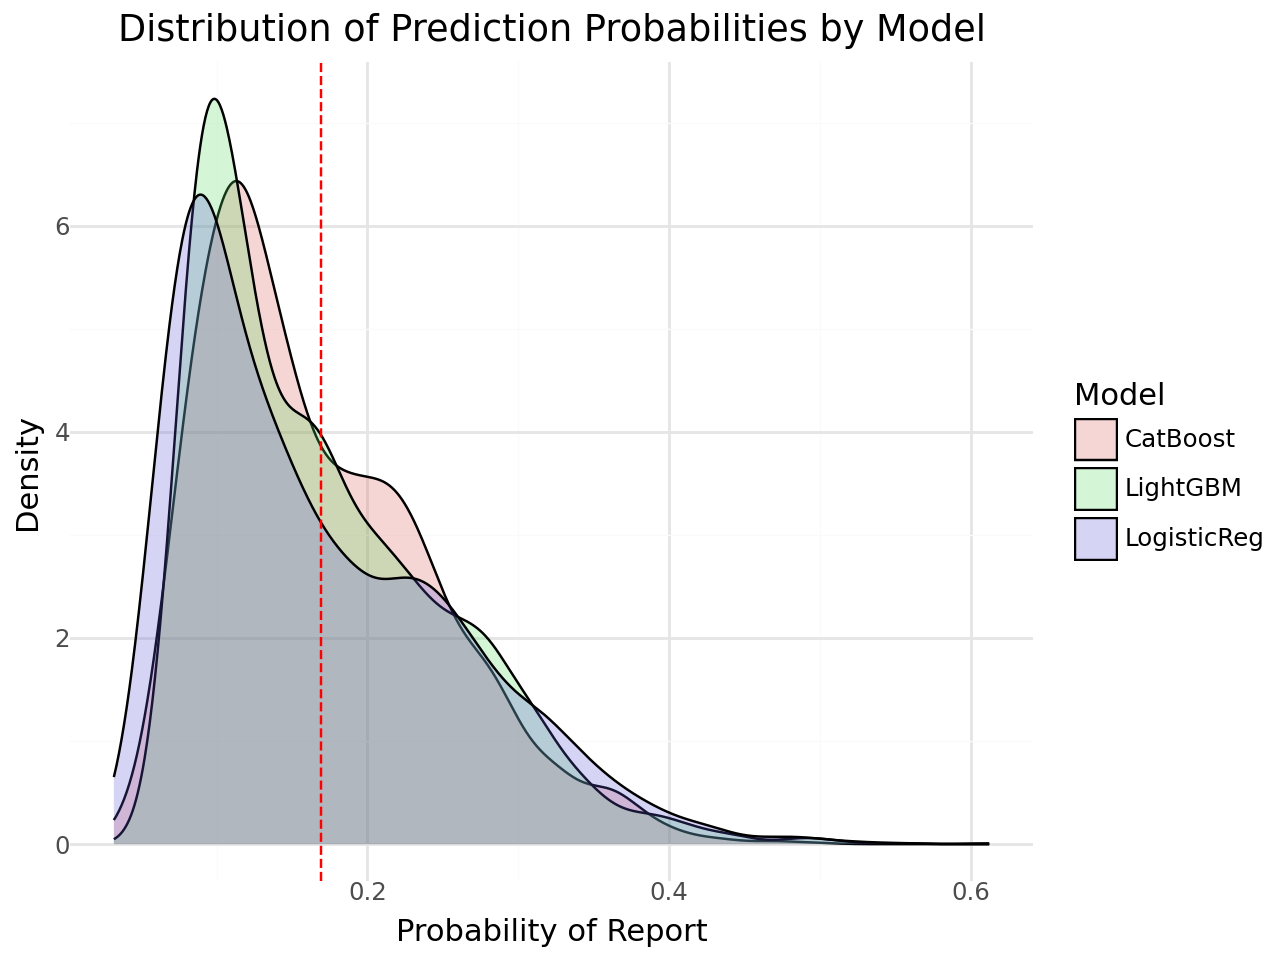

In [18]:
(p9.ggplot(plot_df, p9.aes(x='Probability', fill='Model'))
    + p9.geom_density(position='identity', alpha=0.25)
    + p9.labs(title='Distribution of Prediction Probabilities by Model',
            x='Probability of Report',
            y='Density')
    + p9.geom_vline(xintercept=best_threshold, linetype='dashed', color='red')
    + p9.theme_minimal()
)


The next notebook will interpret the model results from `LightGBM`.